<div style="display: flex; align-items: center;">
    <div style="display: flex; flex-direction: column; align-items: center;">
        <h1 style="text-align: right;">Centro de Investigación en Matemáticas, A.C.</h1>
        <h2 style="text-align: right;">Reconocimiento de Patrones</h2>
        <h3 style="text-align: right;">Tarea 6. Ejercicio 2. Inciso b)</h3>
    </div>
    <img src="Figures/logoCIMAT11.png" alt="CIMAT Logo" width="200" style="float: left;">
</div>


---

In [1]:
import nltk  # Importing the NLTK library, a powerful toolkit for natural language processing.
import string  # Importing the string library for working with strings in Python.
import re  # Importing the regular expression library for pattern matching.
import os  # Importing the os library for interacting with the operating system.
import numpy as np  # Importing NumPy for numerical operations, especially working with arrays.
import pandas as pd  # Importing Pandas for data manipulation and analysis, providing data structures like DataFrames.
import seaborn as sns  # Importing Seaborn for statistical data visualization based on Matplotlib.
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from sklearn.preprocessing import StandardScaler  # Importing StandardScaler from scikit-learn to standardize features by removing the mean and scaling to unit variance.
from sklearn.decomposition import PCA  # Importing Principal Component Analysis (PCA) from scikit-learn for dimensionality reduction techniques.
from collections import Counter  # Importing Counter from the collections library to count occurrences of items in a sequence.
from nltk.corpus import stopwords  # Importing stopwords from the NLTK corpus, which is a list of commonly used words that are often removed from text.
from nltk.stem import SnowballStemmer  # Importing SnowballStemmer from NLTK for stemming text, reducing words to their root form.
from sklearn.feature_extraction.text import CountVectorizer  # Importing CountVectorizer from scikit-learn for converting text data into a matrix of word counts.
from sklearn.model_selection import train_test_split  # Importing train_test_split from scikit-learn for splitting data into training and testing sets.
from sklearn.preprocessing import LabelEncoder  # Importing LabelEncoder from scikit-learn for converting categorical labels into numerical labels.
from sklearn.svm import SVC  # Importing Support Vector Classifier (SVC) from scikit-learn for classification tasks.
from sklearn.metrics import classification_report, balanced_accuracy_score  # Importing classification_report and balanced_accuracy_score from scikit-learn for evaluating classification models.
from sklearn.linear_model import LogisticRegression  # Importing LogisticRegression from scikit-learn for performing logistic regression.
from sklearn.tree import DecisionTreeClassifier, plot_tree  # Importing DecisionTreeClassifier and plot_tree from scikit-learn for building and visualizing decision trees.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import matplotlib.colors as mcolors
from sklearn import manifold

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Construir Bag of Word a partir de textos

In [3]:
# Define preprocessing function
def preprocess(text, stemmer, stop_words):
    # Lowercase the input text to ensure consistent processing.
    text = text.lower()
    # Remove punctuation and numbers from the text.
    # This step helps to remove noise and improves the quality of the processed text.
    text = re.sub(r'[\d]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text into individual words or tokens.
    tokens = text.split()
    # Remove stop words and stem the remaining tokens.
    # Stop words are common words (e.g., "the", "a", "is") that are typically removed to focus on important terms.
    # Stemming reduces words to their root form.
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) >= 2]
    return ' '.join(tokens)

In [4]:
def process_scripts(directory, k, language):
    """
    Processes a directory of text files, applying the preprocessing steps,
    retaining only the k most common words across all texts, and returning
    a CountVectorizer object.

    Args:
        directory: The path to the directory containing the text files.
        k: Number of most common words to retain.

    Returns:
        A tuple (X, vectorizer) where X is the matrix representation of the
        processed texts, and vectorizer is the CountVectorizer used.
    """
    all_texts = []
    seasons = []
    episodes = []

    stemmer = SnowballStemmer(language)  # Or "spanish" if your texts are in Spanish
    stop_words = set(stopwords.words(language))

    # Collect all texts and filenames
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):  # Process only .txt files
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r', encoding='utf-8-sig') as f:
                text = f.read()
                processed_text = preprocess(text, stemmer, stop_words)
                all_texts.append(processed_text)    # Append original processed text for later use
                seasons.append(filename[1:3])     # Save the season number
                episodes.append(filename[4:6])  # Save the episode number

    # Flatten list of lists to a single list and count word frequencies
    all_word_list = [word for text in all_texts for word in text.split()]
    most_common_words = [word for word, _ in Counter(all_word_list).most_common(k)]
    vectorizer = CountVectorizer(min_df=1, vocabulary=most_common_words)
    X = vectorizer.fit_transform(all_texts)

    return X, vectorizer, seasons, episodes

In [5]:
X, vectorizer, seasons, episodes = process_scripts ('./simpsons_scripts',150,"english")

In [6]:
X_dense = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df_episodes = pd.DataFrame({"season": seasons, "episode": episodes})
df_episodes['era'] = df_episodes.apply(lambda row: "golden age" if int(row["season"]) <= 8 else "modern age", axis=1)

# Merge chapter information
df_simpsons_full = pd.concat([X_dense, df_episodes], axis=1)


In [7]:
# Create a LabelEncoder object to convert categorical author names into numerical values.
label_encoder = LabelEncoder()
# Fit the LabelEncoder to the 'author' column of the DataFrame and transform it into numerical values.
# These numerical values are then stored in the 'y' variable.
y = label_encoder.fit_transform(df_episodes['era'])

In [8]:
# Scale the data to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dense)

In [ ]:
# Build the autoencoder
input_dim = X_scaled.shape[1]  # should be 100

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoder
encode1 = Dense(64, activation='relu')(input_layer)
encode2 = Dense(32, activation='relu')(encode1)
reduced = Dense(2, activation='linear')(encode2)  # final 2D representation

# Decoder
decode1 = Dense(32, activation='relu')(reduced)
decode2 = Dense(64, activation='relu')(decode1)
decoded = Dense(input_dim, activation='linear')(decode2)

# Full autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded, name="autoencoder")

# Encoder model (for 2D representation)
encoder = Model(inputs=input_layer, outputs=reduced)

# Compile and train
autoencoder.compile(optimizer=Adam(learning_rate=1e-3,beta_1=0.5), loss=Huber(delta=1.0))

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150)]             0         
                                                                 
 dense (Dense)               (None, 64)                9664      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
 dense_3 (Dense)             (None, 32)                96        
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 150)               

In [10]:
autoencoder.fit(
    X_scaled,
    X_scaled,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
22/22 [==============================] - 3s 12ms/step - loss: 0.3822 - val_loss: 0.3757
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.3752 - val_loss: 0.3662
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.3687 - val_loss: 0.3631
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 0.3652 - val_loss: 0.3607
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.3613 - val_loss: 0.3574
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.3579 - val_loss: 0.3538
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.3556 - val_loss: 0.3519
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 0.3540 - val_loss: 0.3504
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.3530 - val_loss: 0.3496
Epoch 10/100
22/22 [==============================] - 0s 5ms/step - loss: 0.3523 - val_loss: 0.3492
Epoch 11

In [ ]:
# Get 2D encoded data
X_encoded = encoder.predict(X_scaled)

25/25 [==============================] - 0s 3ms/step


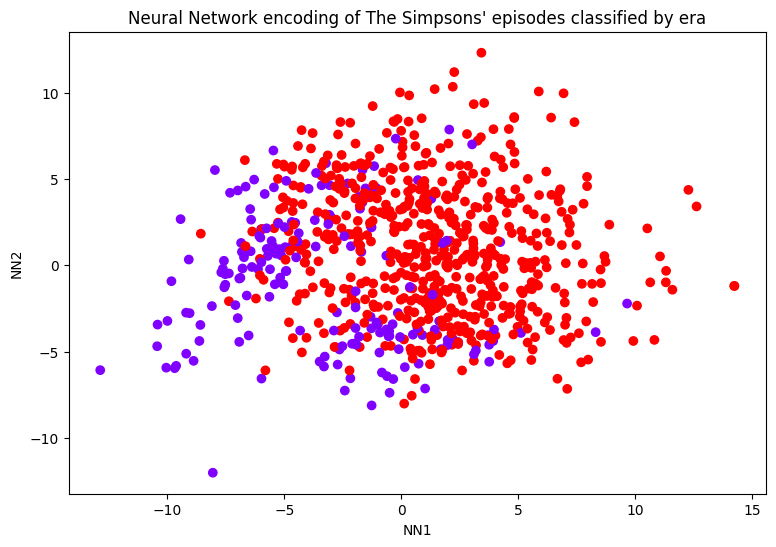

In [29]:
# Create a scatter plot of the data in the Encoder dimensions.
# The color of each point is determined by the corresponding class label.
plt.figure(figsize=(9,6))
plt.scatter(X_encoded[:,0],X_encoded[:,1], c = y, cmap = 'rainbow')
#plt.xlim(-15, 10)
#plt.ylim(-10,5)
# Add a title to the plot.
plt.title("Neural Network encoding of The Simpsons' episodes classified by era")
# Label the x-axis as "NN1" (first Neural Network component)
plt.xlabel("NN{}".format(1))
# Label the y-axis as "NN2" (second Neural Network component)
plt.ylabel("NN{}".format(2))
# Display the plot
plt.show()

In [13]:
# Perform Principal Component Analysis (PCA) to reduce data to 2 dimensions
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)

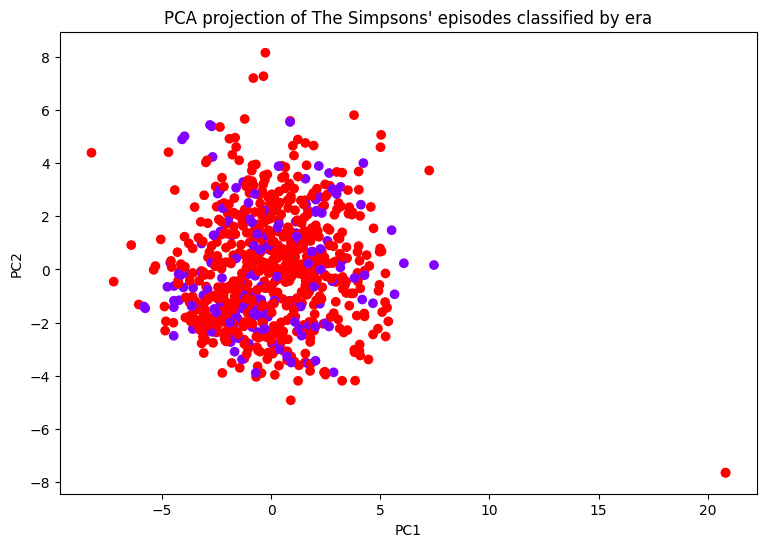

In [30]:
# Create a scatter plot of the data in the first two principal components.
# The color of each point is determined by the corresponding class label.
plt.figure(figsize=(9,6))
plt.scatter(pca_data[:,0],pca_data[:,1], c = y, cmap = 'rainbow')
#plt.xlim(-10, 15)
#plt.ylim(-10,5)
# Add a title to the plot.
plt.title("PCA projection of The Simpsons' episodes classified by era")
# Label the x-axis as "PC1" (first principal component)
plt.xlabel("PC{}".format(1))
# Label the y-axis as "PC2" (second principal component)
plt.ylabel("PC{}".format(2))
# Display the plot
plt.show()

In [15]:
iso = manifold.Isomap(n_components=2)
X_iso = iso.fit_transform(X_scaled)

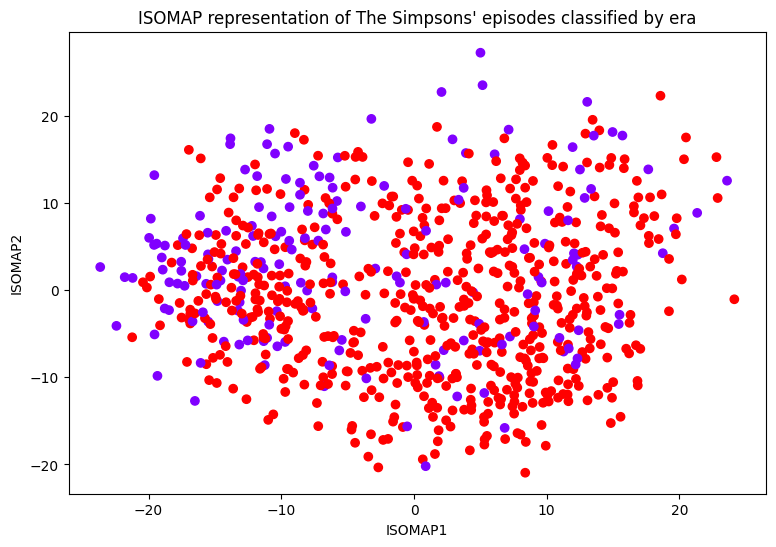

In [31]:
# Create a scatter plot of the data representation via ISOMAP.
# The color of each point is determined by the corresponding class label.
plt.figure(figsize=(9,6))
plt.scatter(X_iso[:,0],X_iso[:,1], c = y, cmap = 'rainbow')
#plt.xlim(-30, 30)
#plt.ylim(-30,30)
# Add a title to the plot.
plt.title("ISOMAP representation of The Simpsons' episodes classified by era")
# Label the x-axis as "NN1" (first Neural Network component)
plt.xlabel("ISOMAP{}".format(1))
# Label the y-axis as "NN2" (second Neural Network component)
plt.ylabel("ISOMAP{}".format(2))
# Display the plot
plt.show()

In [17]:
tsne = manifold.TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

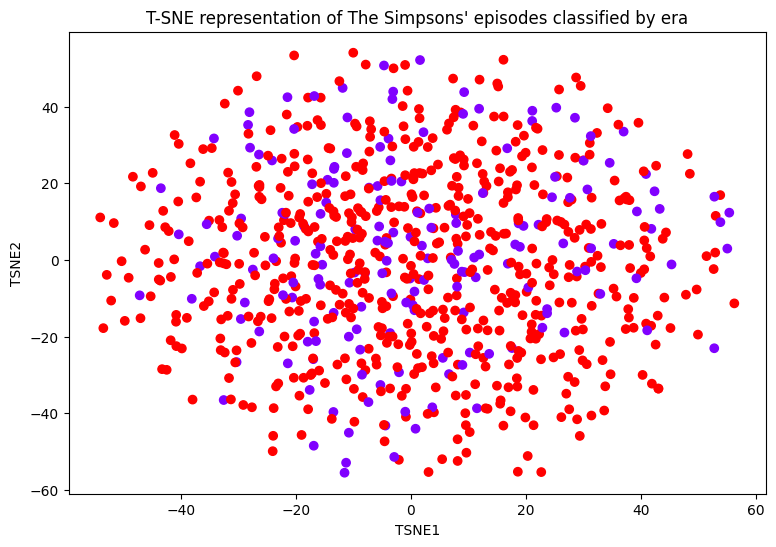

In [32]:
# Create a scatter plot of the data representation via ISOMAP.
# The color of each point is determined by the corresponding class label.
plt.figure(figsize=(9,6))
plt.scatter(X_tsne[:,0],X_tsne[:,1], c = y, cmap = 'rainbow')
#plt.xlim(-25, 25)
#plt.ylim(-25, 25)
# Add a title to the plot.
plt.title("T-SNE representation of The Simpsons' episodes classified by era")
# Label the x-axis as "NN1" (first Neural Network component)
plt.xlabel("TSNE{}".format(1))
# Label the y-axis as "NN2" (second Neural Network component)
plt.ylabel("TSNE{}".format(2))
# Display the plot
plt.show()

En dos dimensiones, parece que el método que mejor separa es el autoencoder. Sin embargo, ningún en método se distingue que los datos sean linealmente separables. A continuación, seguimos con tres dimensiones:

In [ ]:
# Build the autoencoder
input_dim = X_scaled.shape[1]  # should be 100

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoder
encode1 = Dense(64, activation='relu')(input_layer)
encode2 = Dense(32, activation='relu')(encode1)
reduced = Dense(3, activation='linear')(encode2)  # final 3D representation

# Decoder
decode1 = Dense(32, activation='relu')(reduced)
decode2 = Dense(64, activation='relu')(decode1)
decoded = Dense(input_dim, activation='linear')(decode2)

# Full autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded, name="Autoencoder")

# Encoder model (for 3D representation)
encoder = Model(inputs=input_layer, outputs=reduced)

# Compile and train
autoencoder.compile(optimizer=Adam(learning_rate=1e-3,beta_1=0.5), loss=Huber(delta=1.0))

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150)]             0         
                                                                 
 dense_6 (Dense)             (None, 64)                9664      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
 dense_9 (Dense)             (None, 32)                128       
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 150)               

In [20]:
autoencoder.fit(
    X_scaled,
    X_scaled,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
22/22 [==============================] - 2s 20ms/step - loss: 0.3825 - val_loss: 0.3771
Epoch 2/100
22/22 [==============================] - 0s 16ms/step - loss: 0.3776 - val_loss: 0.3722
Epoch 3/100
22/22 [==============================] - 0s 16ms/step - loss: 0.3716 - val_loss: 0.3658
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.3656 - val_loss: 0.3607
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 0.3601 - val_loss: 0.3557
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.3554 - val_loss: 0.3516
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 0.3519 - val_loss: 0.3490
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 0.3495 - val_loss: 0.3474
Epoch 9/100
22/22 [==============================] - 0s 5ms/step - loss: 0.3478 - val_loss: 0.3458
Epoch 10/100
22/22 [==============================] - 0s 5ms/step - loss: 0.3464 - val_loss: 0.3448
Epoch

In [ ]:
# Get 3D encoded data
X_encoded = encoder.predict(X_scaled)

25/25 [==============================] - 0s 2ms/step


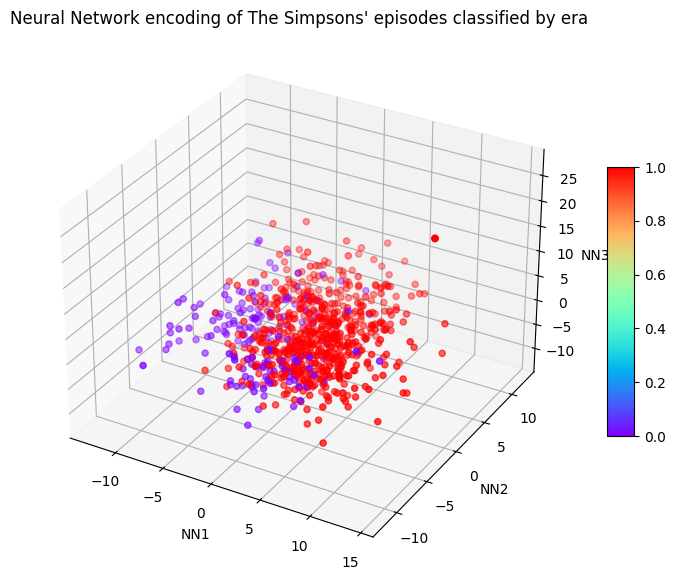

In [22]:
# Create a 3D scatter plot of the data in the encoder dimensions
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D encoded points, colored by class labels `y`
sc = ax.scatter(X_encoded[:, 0], X_encoded[:, 1], X_encoded[:, 2], c=y, cmap='rainbow')

# Add axis labels
ax.set_xlabel('NN1')
ax.set_ylabel('NN2')
ax.set_zlabel('NN3')

# Add a title
ax.set_title("Neural Network encoding of The Simpsons' episodes classified by era")

# Add color bar if desired
plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)

# Display the plot
plt.show()


In [23]:
# Perform Principal Component Analysis (PCA) to reduce data to 2 dimensions
pca = PCA(n_components=3)
pca_data = pca.fit_transform(X_scaled)

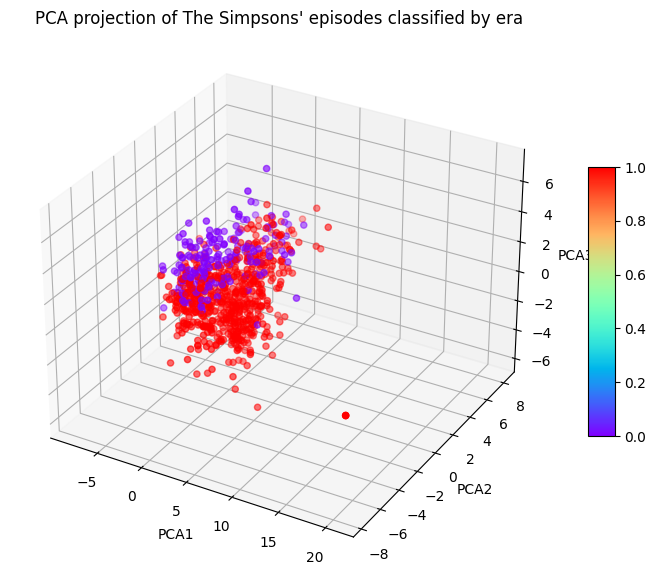

In [33]:
# Create a 3D scatter plot of the data in the encoder dimensions
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D encoded points, colored by class labels `y`
sc = ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=y, cmap='rainbow')

# Add axis labels
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

# Add a title
ax.set_title("PCA projection of The Simpsons' episodes classified by era")

# Add color bar if desired
plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)

# Display the plot
plt.show()


In [25]:
iso = manifold.Isomap(n_components=3)
X_iso = iso.fit_transform(X_scaled)

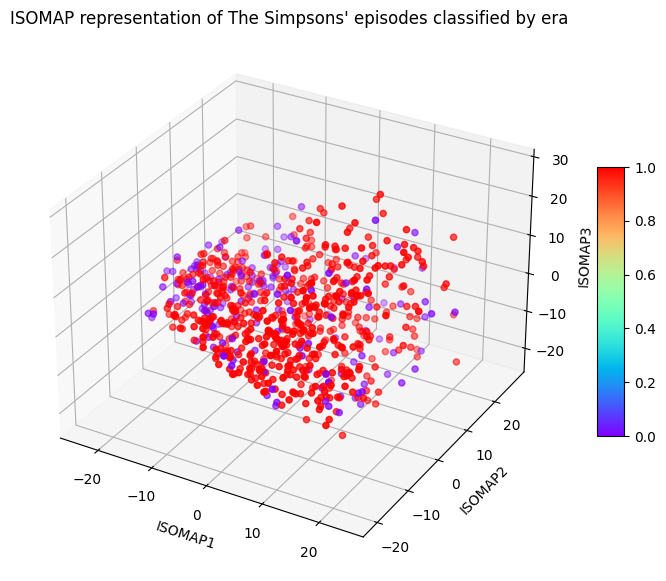

In [34]:
# Create a 3D scatter plot of the data in the encoder dimensions
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D encoded points, colored by class labels `y`
sc = ax.scatter(X_iso[:, 0], X_iso[:, 1], X_iso[:, 2], c=y, cmap='rainbow')

# Add axis labels
ax.set_xlabel('ISOMAP1')
ax.set_ylabel('ISOMAP2')
ax.set_zlabel('ISOMAP3')

# Add a title
ax.set_title("ISOMAP representation of The Simpsons' episodes classified by era")

# Add color bar if desired
plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)

# Display the plot
plt.show()


In [27]:
tsne = manifold.TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

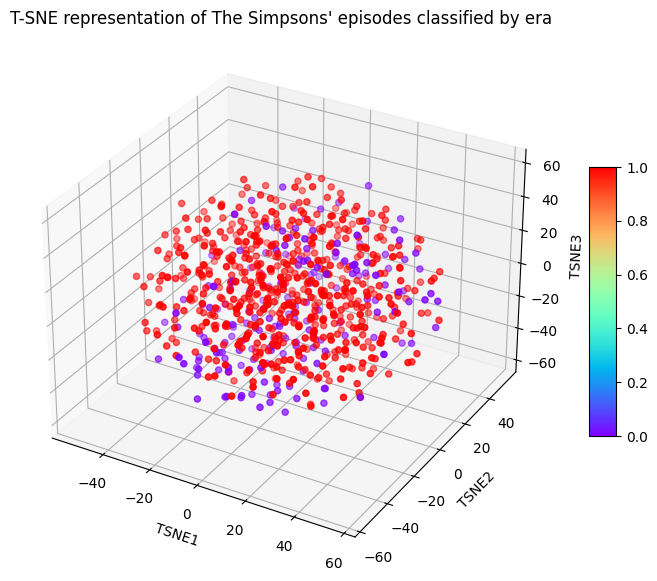

In [35]:
# Create a 3D scatter plot of the data in the encoder dimensions
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D encoded points, colored by class labels `y`
sc = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y, cmap='rainbow')

# Add axis labels
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')

# Add a title
ax.set_title("T-SNE representation of The Simpsons' episodes classified by era")

# Add color bar if desired
plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)

# Display the plot
plt.show()


En este caso, la mejor separación la logra el autoencoder, y en este caso hasta parece factible que se pueda identificar la era de los capítulos de The Simpsons